In [ ]:
from transformers import AutoModelForSeq2SeqLM
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from datasets import DatasetDict
import os
from utils import prepare_prompt

# Dataset Selection

In [ ]:
n_total = 5000

dataset_mlsum = load_dataset("mlsum", "fr", cache_dir="/Data/gabriel-mercier/hf_datasets")
#dataset_wiki = load_dataset("wikipedia", "20220301.fr", cache_dir="/Data/gabriel-mercier/hf_datasets")

dataset_init = dataset_mlsum['train'].shuffle(seed=42).select(range(5000)) 
dataset = dataset_init.select_columns(['text'])

In [ ]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 5000
})


In [ ]:
llm_name = "Qwen/Qwen2.5-32B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(llm_name, 
                                          cache_dir="/Data/gabriel-mercier/hf_models",
                                          padding_side='left') #auto reggressive llm

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Distibution')

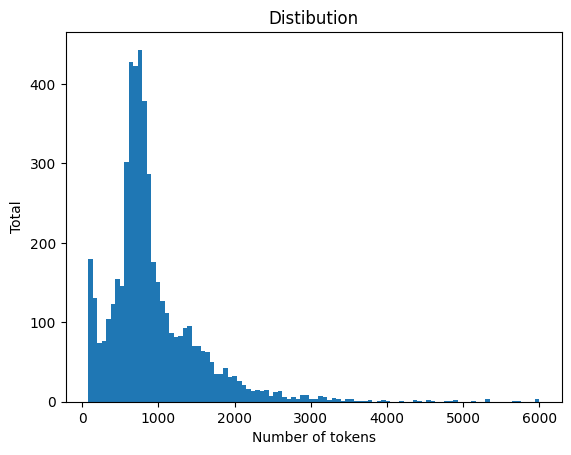

In [ ]:
def get_token_length(example):
    tokens = tokenizer_llm(example["text"], truncation=True, max_length=6000)["input_ids"]
    return {"token_length": len(tokens)}

dataset_token = dataset.map(get_token_length)

plt.hist(dataset_token["token_length"], bins=100)
plt.xlabel("Number of tokens")
plt.ylabel("Total")
plt.title("Distibution")

In [ ]:
max_length = 2500

NameError: name 'torch' is not defined

# Dataset Annotation

In [ ]:
!nvidia-smi

Mon Mar  3 00:52:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 59%   83C    P2            229W /  230W |   20709MiB /  24564MiB |     95%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  
    bnb_4bit_compute_dtype=torch.float16, 
    bnb_4bit_use_double_quant=True,  
    bnb_4bit_quant_type="nf4"
)

model_llm = AutoModelForCausalLM.from_pretrained(
    llm_name,
    cache_dir="/Data/gabriel-mercier/hf_models",
    quantization_config=bnb_config, 
    device_map="auto"  
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:


assistant_start = "Voici le résumé de"

In [ ]:
summary_num_tokens = 250

def generate_summary(text):
    prompt = prepare_prompt({'text':text}, summary_included=False)
    inputs = tokenizer_llm(prompt, return_tensors="pt", truncation=True, max_length=max_length).to(model_llm.device)
    prompt_length = inputs.input_ids.shape[-1] 
    output = model_llm.generate(**inputs, max_new_tokens=summary_num_tokens)
    generated_tokens = output[0][prompt_length:]
    summary = tokenizer_llm.decode(generated_tokens, skip_special_tokens=True)
    summary = summary.split("\n")
    summary = next((s for s in summary if s.strip()), None)
    summary_split = summary.split()
    summary = " ".join(summary_split[:125])
    return summary

In [ ]:
for i in range (10):
    data = dataset[i]
    text = data['text']
    print(text)
    summary = generate_summary(text)
    print("Summary :", summary)
    print(len(summary.split()))

Willem-Alexander, incognito. Jason Reed / REUTERS Willem-Alexander, devenu roi des Pays-Bas en 2013, exerçait un autre métier à temps partiel depuis vingt et un ans : pilote de ligne pour la compagnie néerlandaise KLM. Le monarque a révélé sa double vie au journal De Telegraaf, le 18 mai. Il raconte qu’il volait au moins deux fois par mois sur des Fokker 70 couvrant des courtes distances en Europe du Nord. Il officiait en tant que copilote mais ne révélait jamais sa vraie identité à ses passagers. « L’avantage, c’est que je pouvais toujours les accueillir au nom du capitaine et de l’équipage. Je n’étais pas obligé de dire mon nom. » Il se souvient qu’avant le 11-Septembre, quand l’accès au cockpit était encore autorisé aux plus curieux, « des gens venaient régulièrement jeter un coup d’œil et étaient surpris et contents de m’y voir assis ». Mais tout compte fait, sur deux décennies, peu de gens ont reconnu sa voix – « de toute façon, la plupart des gens n’écoutent pas » – ou son visage

KeyboardInterrupt: 

In [ ]:
num_shards = 20

for i in range(num_shards):
    output_file = f"dataset_part_{i}.json"
    
    if os.path.exists(output_file):
        print(f"Le shard {i} est déjà traité, on passe au suivant.")
        continue

    shard = dataset.shard(num_shards=num_shards, index=i)
    processed_shard = shard.map(lambda x: {"summary": generate_summary(x["text"])})
    processed_shard.to_json(output_file)
    print(f"Shard {i} traité et sauvegardé dans {output_file}.")

Le shard 0 est déjà traité, on passe au suivant.
Le shard 1 est déjà traité, on passe au suivant.
Le shard 2 est déjà traité, on passe au suivant.
Le shard 3 est déjà traité, on passe au suivant.
Le shard 4 est déjà traité, on passe au suivant.
Le shard 5 est déjà traité, on passe au suivant.
Le shard 6 est déjà traité, on passe au suivant.
Le shard 7 est déjà traité, on passe au suivant.
Le shard 8 est déjà traité, on passe au suivant.
Le shard 9 est déjà traité, on passe au suivant.
Le shard 10 est déjà traité, on passe au suivant.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 11 traité et sauvegardé dans dataset_part_11.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 12 traité et sauvegardé dans dataset_part_12.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 13 traité et sauvegardé dans dataset_part_13.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 14 traité et sauvegardé dans dataset_part_14.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 15 traité et sauvegardé dans dataset_part_15.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Shard 16 traité et sauvegardé dans dataset_part_16.json.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

In [ ]:
import os
from datasets import load_dataset, concatenate_datasets

num_shards = 20
shard_files = []

# Récupérer la liste des fichiers existants
for i in range(num_shards):
    file_path = f"dataset_part_{i}.json"
    if os.path.exists(file_path):
        shard_files.append(file_path)
    else:
        print(f"Shard {i} introuvable.")

if not shard_files:
    print("Aucun shard trouvé.")
else:
    # Charger chaque shard dans une liste de Dataset
    datasets_list = [load_dataset("json", data_files=file_path)["train"] for file_path in shard_files]
    # Fusionner les datasets
    merged_dataset = concatenate_datasets(datasets_list)
    
    # Sauvegarder le dataset fusionné dans un nouveau fichier JSON
    merged_dataset.to_json("merged_dataset.json")
    print("Dataset fusionné et sauvegardé dans merged_dataset.json")


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Dataset fusionné et sauvegardé dans merged_dataset.json


In [ ]:
print(dataset)

Dataset({
    features: ['text', 'token_length', 'summary'],
    num_rows: 100
})


In [ ]:
dataset.to_json("summarization_dataset.json")


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

485812

In [ ]:
n_total = 5000

dataset_mlsum = load_dataset("mlsum", "fr", cache_dir="/Data/gabriel-mercier/hf_datasets")
#dataset_wiki = load_dataset("wikipedia", "20220301.fr", cache_dir="/Data/gabriel-mercier/hf_datasets")

dataset_init = dataset_mlsum['train'].shuffle(seed=42).select(range(5000)) 
dataset = dataset_init.select_columns(['text'])

In [ ]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 5000
})


In [ ]:
llm_name = "Qwen/Qwen2.5-32B-Instruct"
tokenizer_llm = AutoTokenizer.from_pretrained(llm_name, 
                                          cache_dir="/Data/gabriel-mercier/hf_models",
                                          padding_side='left') #auto reggressive llm

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Distibution')

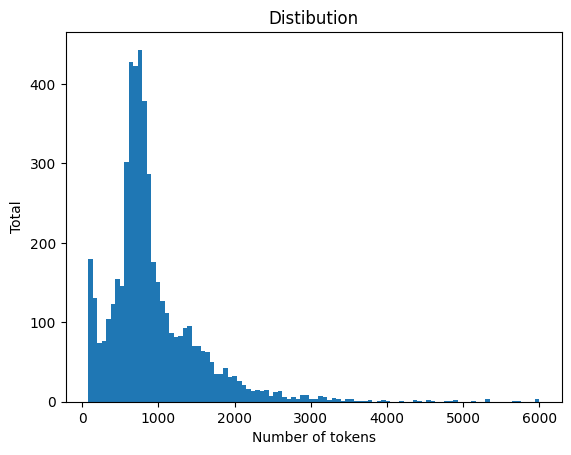

In [ ]:
def get_token_length(example):
    tokens = tokenizer_llm(example["text"], truncation=True, max_length=6000)["input_ids"]
    return {"token_length": len(tokens)}

dataset_token = dataset.map(get_token_length)

plt.hist(dataset_token["token_length"], bins=100)
plt.xlabel("Number of tokens")
plt.ylabel("Total")
plt.title("Distibution")

In [ ]:
max_length = 2500

NameError: name 'torch' is not defined